<a href="https://colab.research.google.com/github/IdealisticINTJ/My_Machine_Learning_Projects/blob/main/MBTI_PersonalityPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

In [3]:
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [4]:
# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [5]:
# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE


In [6]:
# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [7]:
#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [12]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [13]:
!kaggle datasets download -d datasnaek/mbti-type

 70% 17.0M/24.4M [00:01<00:00, 13.0MB/s]
100% 24.4M/24.4M [00:01<00:00, 16.9MB/s]


In [14]:
!unzip \*.zip  && rm *.zip

Archive:  mbti-type.zip
  inflating: mbti_1.csv              


In [16]:
data_set = pd.read_csv("mbti_1.csv")
data_set.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [17]:
data_set.isnull().any()

type     False
posts    False
dtype: bool

In [18]:
nRow, nCol = data_set.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8675 rows and 2 columns


In [19]:
data_set.dtypes

type     object
posts    object
dtype: object

In [20]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [21]:
data_set.describe(include=['object'])

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=DnAt0xpO2HU|||...
freq,1832,1


In [22]:
types = np.unique(np.array(data_set['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [23]:
total = data_set.groupby(['type']).count()*50
total

,posts
type,
ENFJ,9500
ENFP,33750
ENTJ,11550
ENTP,34250
ESFJ,2100
ESFP,2400
ESTJ,1950
ESTP,4450
INFJ,73500


Text(0.5, 1.0, 'Total number of posts for each personality type')

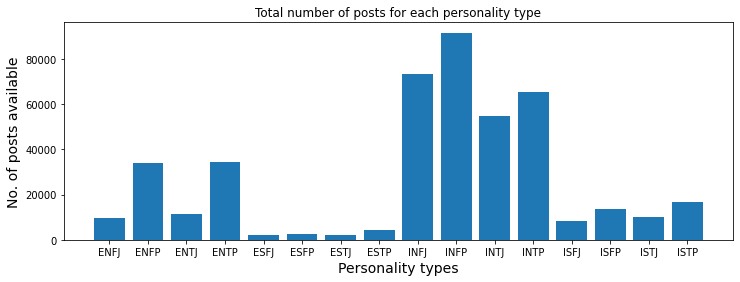

In [24]:
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total number of posts for each personality type')

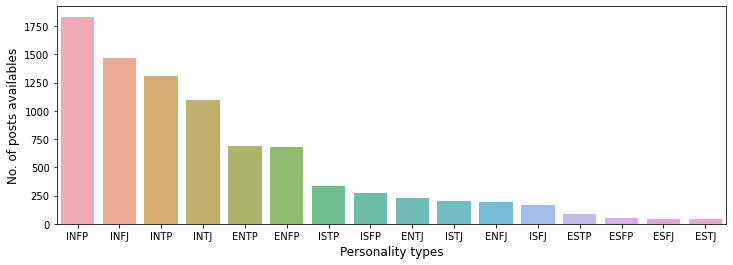

In [25]:
cnt_srs = data_set['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of posts availables', fontsize=12)
plt.show()

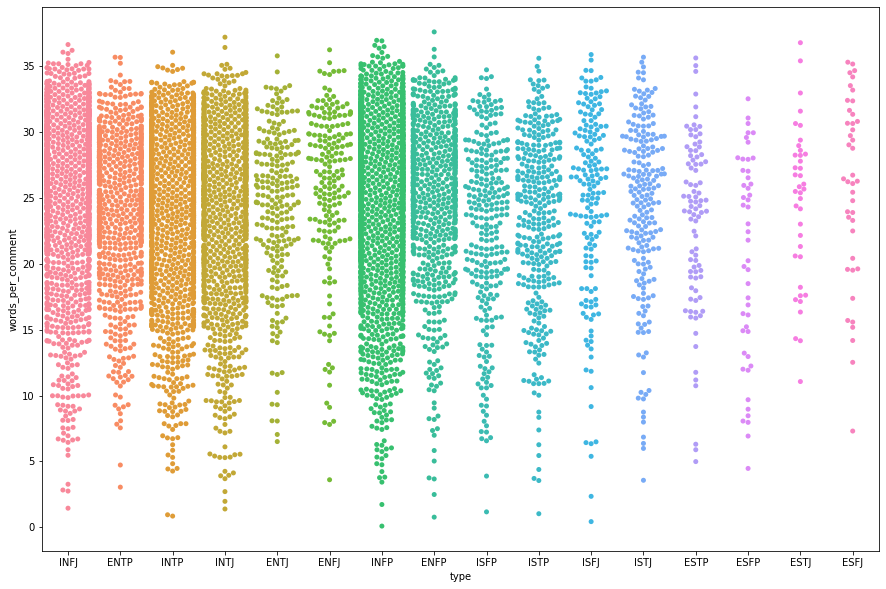

In [26]:
df = data_set.copy()
# This function counts the no. of words in each post of a user.
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=df)

<Figure size 1080x720 with 0 Axes>

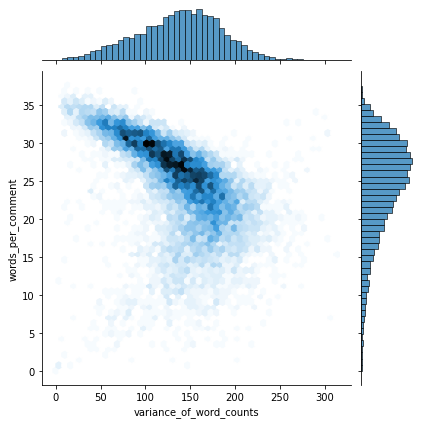

In [27]:
plt.figure(figsize=(15,10))
sns.jointplot("variance_of_word_counts", "words_per_comment", data=df, kind="hex")

<Figure size 1728x360 with 0 Axes>

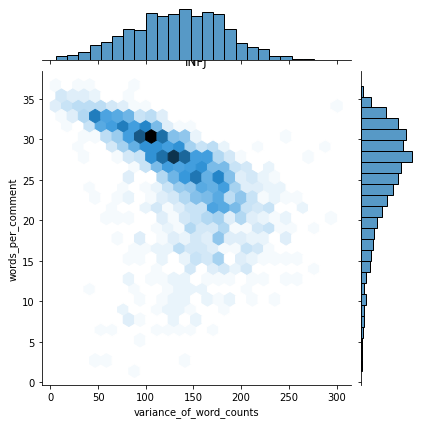

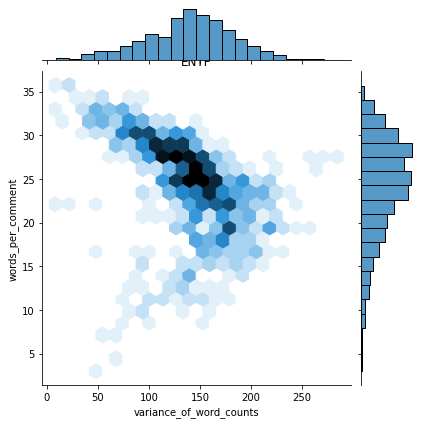

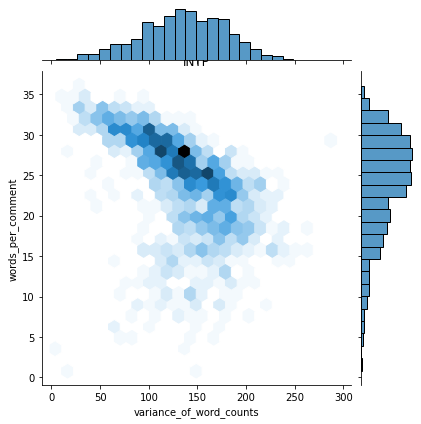

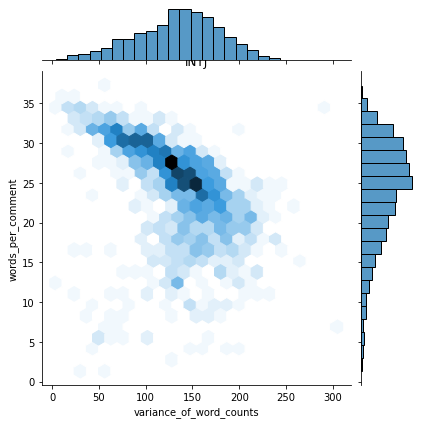

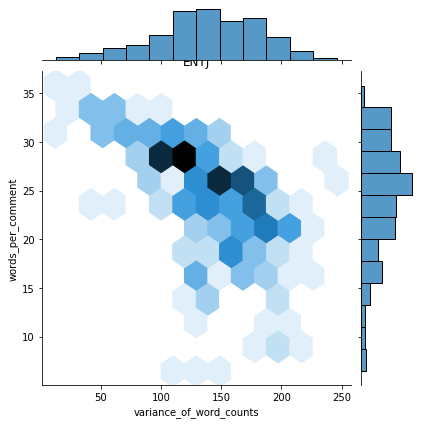

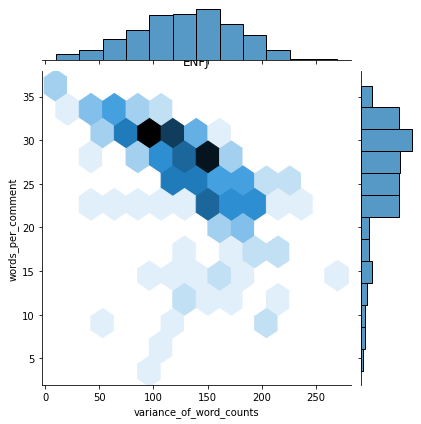

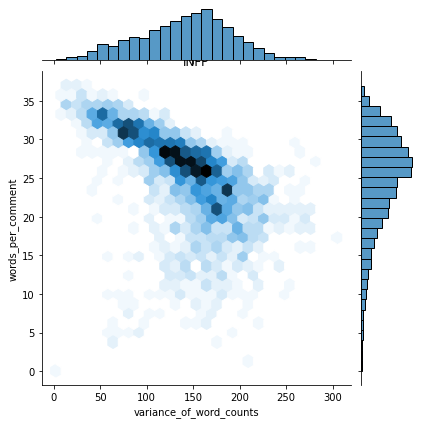

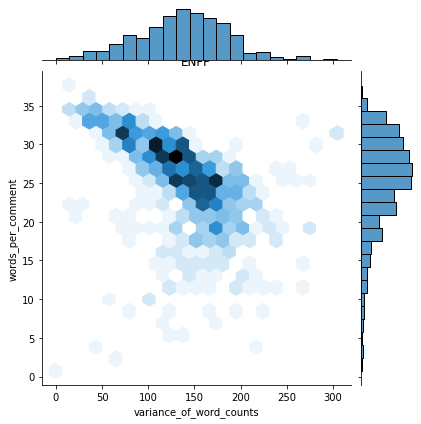

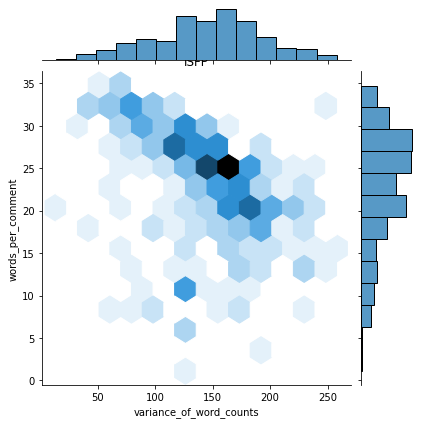

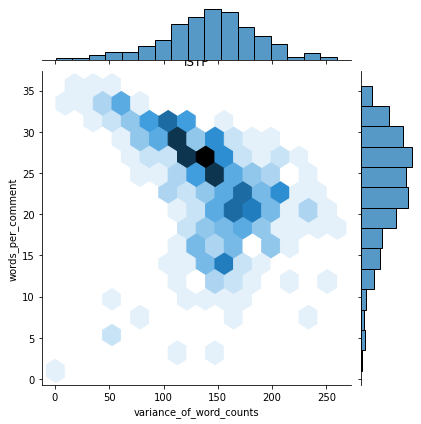

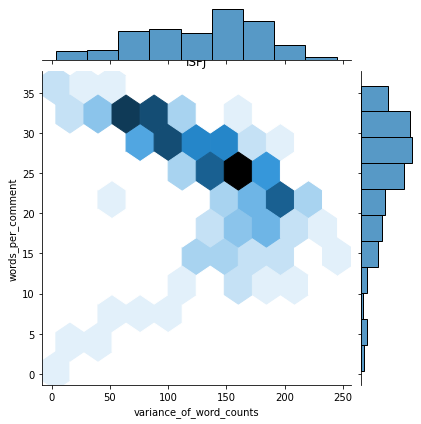

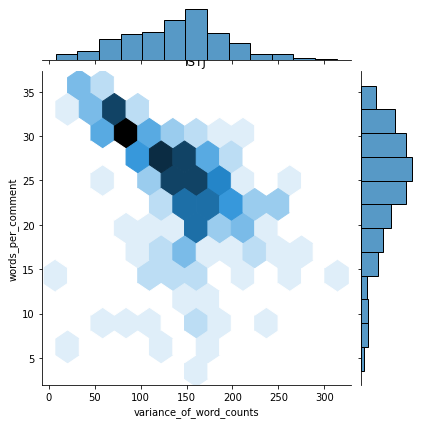

In [28]:
def plot_jointplot(mbti_type, axs, titles):
    df_1 = df[df['type'] == mbti_type]
    sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_1, kind="hex", ax = axs, title = titles)

plt.figure(figsize=(24, 5))    
i = df['type'].unique()
k = 0

for m in range(1,3):
  for n in range(1,7):
    df_1 = df[df['type'] == i[k]]
    sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_1, kind="hex" )
    plt.title(i[k])
    k+=1
plt.show()

Text(0.5, 1.0, 'The Distribution of Llengths of all 50 Posts')

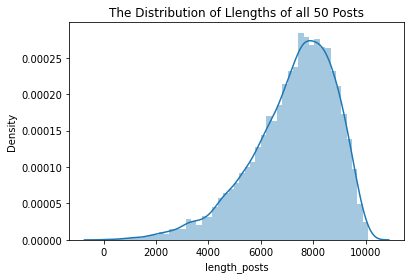

In [29]:
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("The Distribution of Llengths of all 50 Posts")

In [30]:
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546)]

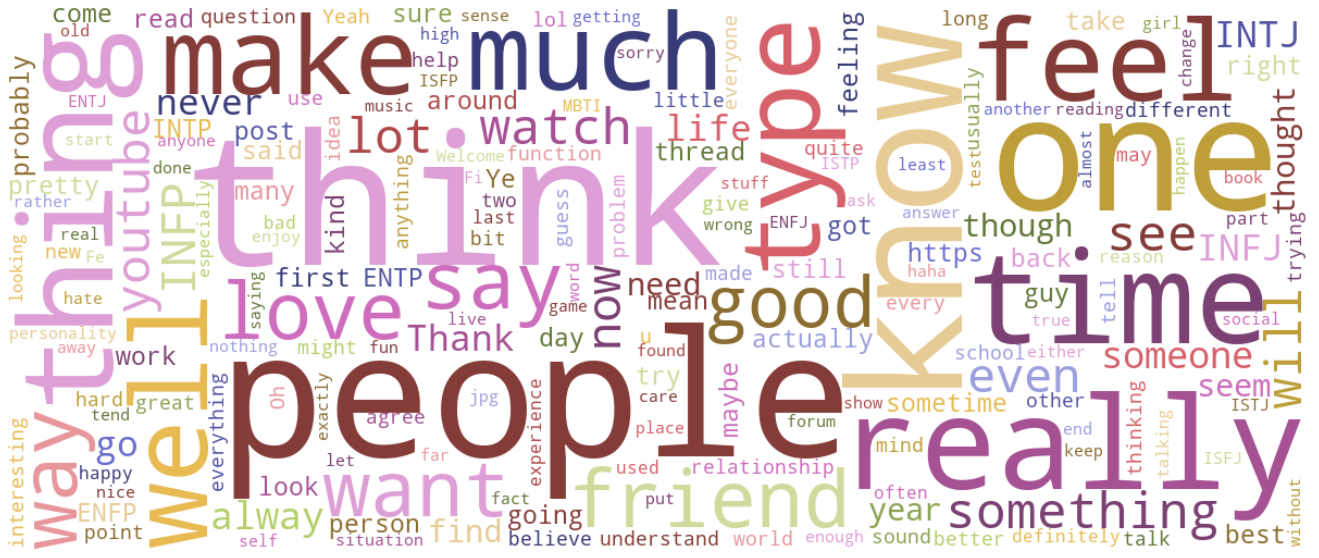

In [31]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

plt.figure(figsize=(25,10))
# Generating the word cloud and interpolation.
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

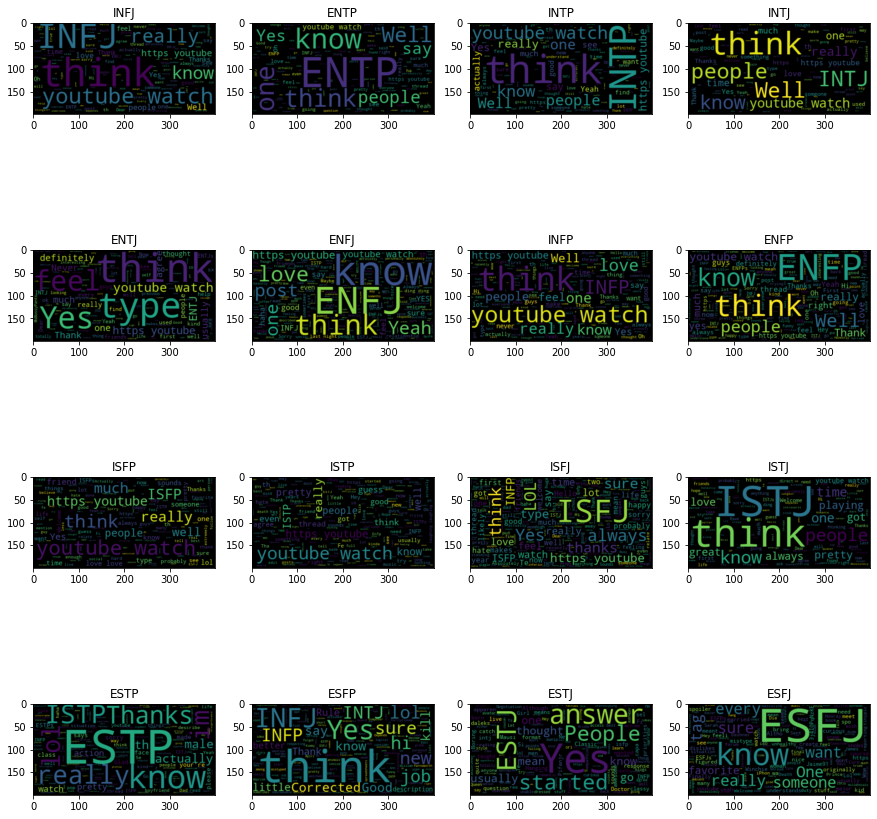

In [32]:
fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,len(df['type'].unique())))
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [33]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))
print("5 posts from the start are as follows:")
posts[0:5]

Number of users 8675
Number of posts 422845
5 posts from the start are as follows:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]

In [34]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()
# Regex usage 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    # Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    # Removing multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    # Removing Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    # Converting posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Removing multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 
    # Removing very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    # Removing MBTI Personality Words - crucial to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

# Preprocessing of entered text
new_df = preprocess_text(data_set)

In [35]:
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


In [36]:
# Feature engineering
new_df.head()

,type,posts,no. of. words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming eo...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other eos...,777
4,ENTJ,youre fired eostokendot thats another silly...,402


In [37]:
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df['type'])

target = new_df['type of encoding'] 

In [39]:
new_df.head(15)

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2
5,INTJ,eostokendot science perfect eostokendo...,245,10
6,INFJ,cant draw nails haha eostokendot those w...,970,8
7,INTJ,tend build collection things desktop th...,140,10
8,INFJ,sure thats good question eostokendot dist...,522,8
9,INTP,this position where have actually pe...,130,11


In [41]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [43]:
vect = CountVectorizer(stop_words='english') 

train =  vect.fit_transform(new_df["posts"])

In [44]:
train.shape

(8466, 98555)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5079, 98555) (5079,) (3387, 98555) (3387,)


In [46]:
accuracies = {}

#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# Make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.53%


In [50]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.52%


In [51]:
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 38.29%


In [52]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.22%


Accuracy: 16.45%


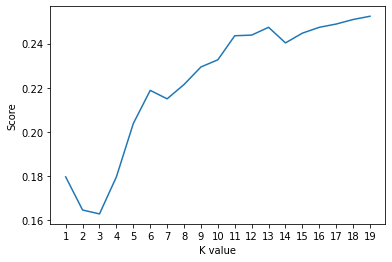

Maximum KNN Score is 25.24%


In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))


In [54]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# Evaluating predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 35.52%


In [55]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5672, 98555) (5672,) (2794, 98555) (2794,)


In [56]:
accuracies = {}

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# Make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 37.87%


In [57]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluating predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.16%


In [58]:
data = pd.read_csv("mbti_1.csv")
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [59]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [60]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


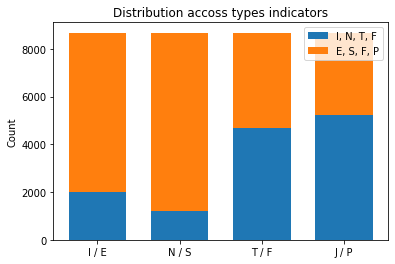

In [61]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    
width = 0.7           

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

In [62]:
data[['IE','NS','TF','JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,-0.069573,0.161939
NS,-0.045899,1.000000,-0.080954,0.014922
TF,-0.069573,-0.080954,1.000000,-0.004673
JP,0.161939,0.014922,-0.004673,1.000000


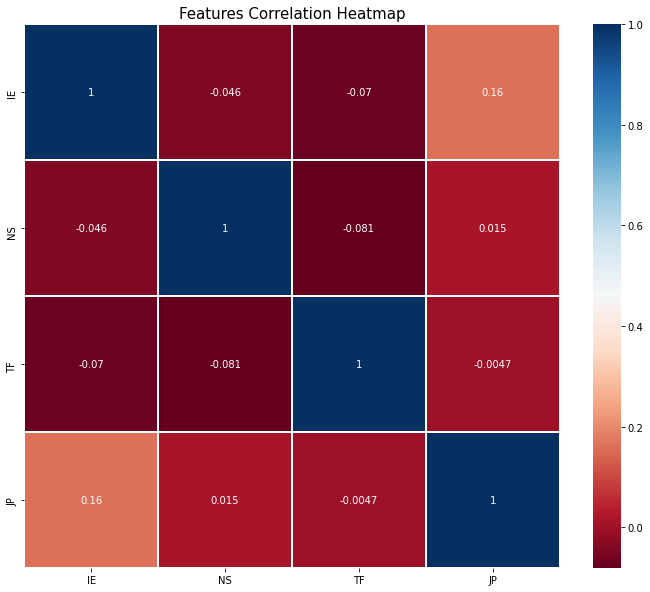

In [63]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

In [66]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)
